In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf


In [2]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [3]:
# **Loading Dataset**
data_train = np.load("C:/Users/PALLAVI/Downloads/train.npz", allow_pickle=True)
x_train = data_train['images']  
y_train = data_train['labels'] 

data_test = np.load("C:/Users/PALLAVI/Downloads/test.npz", allow_pickle=True)
x_test = data_test['images']    
y_test = data_test['labels']   


In [4]:
train_data_generator = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,  
    
)


x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
#                                     brightness_range=[0.5, 1.5],
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(5):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

1440
1440
1512
1512
150
150
180
180


In [5]:
# **Data Preprocessing**
x_train = np.array(x_train)
x_test = np.array(x_test)

# Initialize new arrays for resized images
x_train_resized = np.empty((x_train.shape[0], 224, 224, 3), dtype=np.float32)
x_test_resized = np.empty((x_test.shape[0], 224, 224, 3), dtype=np.float32)


for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (224, 224))  # DenseNet201 requires 224x224 input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train_resized[i] = img

for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test_resized[i] = img

# Normalize the images
x_train_resized /= 255.0
x_test_resized /= 255.0

# Use the resized images for training and testing
x_train = x_train_resized
x_test = x_test_resized

# Encoding labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [6]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)


In [7]:
from tensorflow.keras.layers import BatchNormalization
def create_densenet201_model(input_shape=(224, 224, 3)):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dropout(0.5)(x)  
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.03))(x) 
    x = BatchNormalization()(x)  
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [8]:
model = create_densenet201_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 94080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 94080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,021,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,343,554 (92.86 MB)

 Trainable params: 6,021,442 (22.97 MB)

 Non-trainable params: 18,322,112 (69.89 MB)

In [9]:

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - accuracy: 0.7786 - loss: 2.8452 - val_accuracy: 0.5889 - val_loss: 3.6801
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.9512 - loss: 1.2772 - val_accuracy: 0.6778 - val_loss: 1.7058
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.9725 - loss: 0.7093 - val_accuracy: 0.7000 - val_loss: 1.1794
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.9738 - loss: 0.5124 - val_accuracy: 0.8333 - val_loss: 0.7085
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 192s 8s/step - accuracy: 0.9734 - loss: 0.3999 - val_accuracy: 0.8667 - val_loss: 0.5879
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.9619 - loss: 0.4205 - val_accuracy: 0.9000 - val_loss: 0.5621
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - accuracy: 0.9741 - loss: 0.3949 - val_accuracy: 0.7778 - val_loss: 0.8777
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 171s 7s/step - accuracy: 0.9834 - loss: 0.3729 - val_accuracy: 0.8222 - v

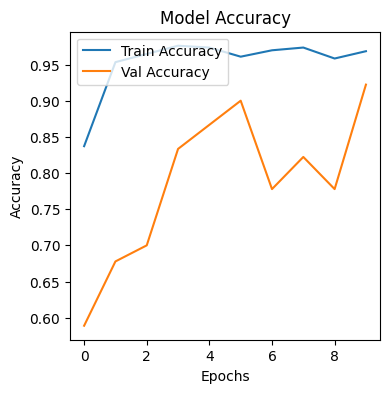

In [12]:
# **Visualization of Training History**
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()



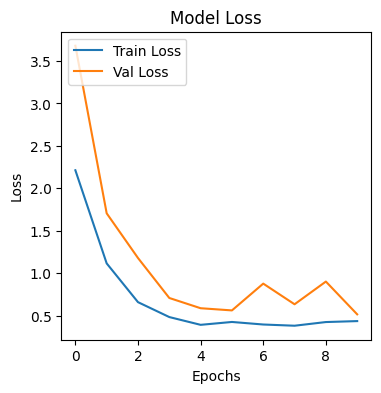

In [13]:
#Loss
plt.figure(figsize=(4,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()


In [14]:
# **Evaluation**
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 14s/step
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        46
           1       0.97      0.86      0.92        44

    accuracy                           0.92        90
   macro avg       0.93      0.92      0.92        90
weighted avg       0.93      0.92      0.92        90



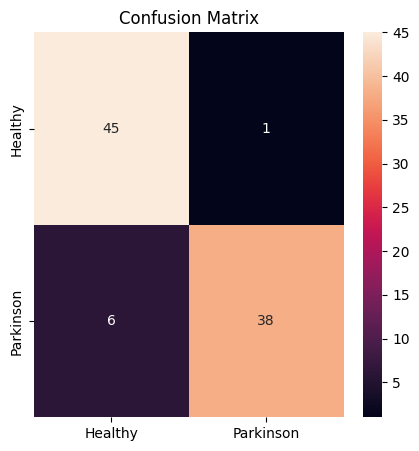

In [15]:
# **Confusion Matrix**
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=['Healthy', 'Parkinson'], columns=['Healthy', 'Parkinson'])
plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# **Testing with Sample Images**
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread("C:/Users/PALLAVI/OneDrive/Desktop/parkinson/wave/wave/testing/healthy/V03HO01.png")
image_parkinson = cv2.imread("C:/Users/PALLAVI/OneDrive/Desktop/parkinson/wave/wave/testing/parkinson/V09PO01.png")

def prepare_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

In [17]:
image_healthy_prepared = prepare_image(image_healthy)
image_parkinson_prepared = prepare_image(image_parkinson)
ypred_healthy = model.predict(image_healthy_prepared)
ypred_parkinson = model.predict(image_parkinson_prepared)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


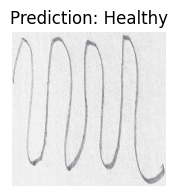

In [18]:

plt.figure(figsize=(2, 2))
plt.imshow(image_healthy_prepared[0])
plt.axis('off')
plt.title(f'Prediction: {labels[np.argmax(ypred_healthy[0])]}')
plt.show()

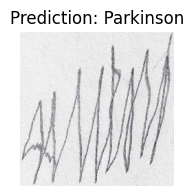

In [19]:

plt.figure(figsize=(2, 2))
plt.imshow(image_parkinson_prepared[0])
plt.axis('off')
plt.title(f'Prediction: {labels[np.argmax(ypred_parkinson[0])]}')
plt.show()